In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
L_MAX = 100_000_000   # maximum loan (VND) - 100 million
K = 2.5                # sensitivity to default risk
INCOME_FACTOR = 6      # income-based cap multiplier (DTI ratio consideration)
MIN_LOAN = 5_000_000   # minimum loan amount (5 million VND)
RISK_TIERS = {
    'excellent': {'min_prob': 0.0, 'max_prob': 0.1, 'max_multiplier': 1.0},
    'good': {'min_prob': 0.1, 'max_prob': 0.2, 'max_multiplier': 0.8},
    'fair': {'min_prob': 0.2, 'max_prob': 0.35, 'max_multiplier': 0.6},
    'poor': {'min_prob': 0.35, 'max_prob': 0.5, 'max_multiplier': 0.4},
    'high_risk': {'min_prob': 0.5, 'max_prob': 1.0, 'max_multiplier': 0.2}
}

In [3]:
# Load trained LightGBM model and threshold
model = joblib.load(r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lightgbm_baseline_model.pkl")
best_threshold = joblib.load(r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\best_threshold.pkl")

print(f"Model loaded successfully.")
print(f"Optimal decision threshold: {best_threshold:.4f}")

Model loaded successfully.
Optimal decision threshold: 0.1430


In [4]:
def calculate_loan_amount(default_prob, income, existing_debt=0, employment_length=0, 
                          credit_history_length=0, num_credits=0):
    """
    Calculate maximum loan amount based on:
    1. Default probability (from LightGBM model)
    2. Income-based capacity (DTI ratio)
    3. Credit history quality
    4. Employment stability
    
    Parameters:
    -----------
    default_prob : float
        Predicted probability of default (0-1)
    income : float
        Annual income in VND
    existing_debt : float
        Current total debt amount
    employment_length : float
        Years of employment
    credit_history_length : float
        Years of credit history
    num_credits : int
        Number of existing credit accounts
        
    Returns:
    --------
    dict with loan_amount, risk_tier, approval_status, and details
    """
    
    # 1. Risk-based loan cap using exponential decay
    # L(p) = L_max * exp(-K * p)
    risk_based_limit = L_MAX * np.exp(-K * default_prob)
    
    # 2. Income-based capacity (DTI rule: monthly payment ≤ 40% of monthly income)
    # Assuming 12-month repayment period
    monthly_income = income / 12
    max_monthly_payment = monthly_income * 0.4  # 40% DTI ratio
    existing_monthly_debt = existing_debt / 12
    available_payment_capacity = max_monthly_payment - existing_monthly_debt
    income_based_limit = max(0, available_payment_capacity * 12 * INCOME_FACTOR)
    
    # 3. Credit history adjustment factor
    history_factor = 1.0
    if credit_history_length > 0:
        # Bonus for longer credit history (up to 20% increase)
        history_factor += min(0.2, credit_history_length / 50)
    else:
        # Penalty for no credit history (30% reduction)
        history_factor *= 0.7
    
    # 4. Employment stability adjustment
    employment_factor = 1.0
    if employment_length >= 5:
        employment_factor = 1.15  # 15% bonus for 5+ years
    elif employment_length >= 2:
        employment_factor = 1.05  # 5% bonus for 2-5 years
    elif employment_length < 1:
        employment_factor = 0.85  # 15% penalty for <1 year
    
    # 5. Credit diversity factor
    diversity_factor = 1.0
    if num_credits > 0:
        diversity_factor = min(1.1, 1 + (num_credits * 0.02))  # Up to 10% bonus
    
    # Combined adjustment
    adjustment_factor = history_factor * employment_factor * diversity_factor
    
    # Apply risk tier multiplier
    risk_tier = get_risk_tier(default_prob)
    tier_multiplier = RISK_TIERS[risk_tier]['max_multiplier']
    
    # Calculate final loan amount
    base_amount = min(risk_based_limit, income_based_limit)
    adjusted_amount = base_amount * adjustment_factor * tier_multiplier
    
    # Apply floor and ceiling
    final_amount = np.clip(adjusted_amount, MIN_LOAN, L_MAX)
    
    # Determine approval status
    if default_prob >= 0.5:
        approval_status = "REJECTED"
        final_amount = 0
    elif default_prob >= best_threshold:
        approval_status = "CONDITIONAL"  # Requires manual review
    else:
        approval_status = "APPROVED"
    
    return {
        'loan_amount': round(final_amount, -3),  # Round to nearest 1000
        'risk_tier': risk_tier,
        'approval_status': approval_status,
        'default_probability': round(default_prob, 4),
        'details': {
            'risk_based_limit': round(risk_based_limit, -3),
            'income_based_limit': round(income_based_limit, -3),
            'adjustment_factor': round(adjustment_factor, 3),
            'tier_multiplier': tier_multiplier,
            'dti_ratio': round((existing_debt / 12) / monthly_income, 3) if monthly_income > 0 else 0
        }
    }


def get_risk_tier(default_prob):
    """Classify borrower into risk tier based on default probability"""
    for tier, bounds in RISK_TIERS.items():
        if bounds['min_prob'] <= default_prob < bounds['max_prob']:
            return tier
    return 'high_risk'

In [5]:
# Load test data to demonstrate
X_train, X_test, y_train, y_test = joblib.load(
    r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\processed_data_lgbm.pkl"
)

# Get predictions
y_prob = model.predict_proba(X_test)[:, 1]

print(f"Test data loaded: {X_test.shape[0]} samples")
print(f"Feature columns: {X_test.shape[1]}")

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Test data loaded: 61503 samples
Feature columns: 64


In [6]:
# Create loan amount estimates for test set
# Assuming these features exist in your dataset - adjust column names as needed
income_col = 'AMT_INCOME_TOTAL' if 'AMT_INCOME_TOTAL' in X_test.columns else X_test.columns[0]
debt_col = 'AMT_CREDIT' if 'AMT_CREDIT' in X_test.columns else None
employment_col = 'DAYS_EMPLOYED' if 'DAYS_EMPLOYED' in X_test.columns else None

# Calculate loan amounts for sample customers
results = []
for i in range(min(100, len(X_test))):  # Sample first 100
    income = X_test[income_col].iloc[i]
    existing_debt = X_test[debt_col].iloc[i] if debt_col else 0
    employment_days = abs(X_test[employment_col].iloc[i]) if employment_col else 365
    employment_years = employment_days / 365
    
    # Get credit history features if available
    credit_history = 0
    if 'DAYS_CREDIT_mean' in X_test.columns:
        credit_history = abs(X_test['DAYS_CREDIT_mean'].iloc[i]) / 365
    
    num_credits = 0
    if 'bureau_CREDIT_ACTIVE_Active_count' in X_test.columns:
        num_credits = X_test['bureau_CREDIT_ACTIVE_Active_count'].iloc[i]
    
    loan_result = calculate_loan_amount(
        default_prob=y_prob[i],
        income=income,
        existing_debt=existing_debt,
        employment_length=employment_years,
        credit_history_length=credit_history,
        num_credits=num_credits
    )
    
    loan_result['actual_default'] = y_test.iloc[i]
    results.append(loan_result)

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nLoan Amount Estimation Results (First 10 samples):")
print(results_df[['loan_amount', 'risk_tier', 'approval_status', 'default_probability', 'actual_default']].head(10))


Loan Amount Estimation Results (First 10 samples):
   loan_amount  risk_tier approval_status  default_probability  actual_default
0    5000000.0  excellent        APPROVED               0.0345               0
1    5000000.0       fair     CONDITIONAL               0.2133               0
2    5000000.0       fair     CONDITIONAL               0.2601               0
3    5000000.0  excellent        APPROVED               0.0534               0
4    5000000.0  excellent        APPROVED               0.0272               0
5    5000000.0  excellent        APPROVED               0.0898               0
6    5000000.0  excellent        APPROVED               0.0663               0
7    5000000.0  excellent        APPROVED               0.0099               0
8    5000000.0       good        APPROVED               0.1113               0
9    5000000.0       fair     CONDITIONAL               0.2691               1


In [7]:
# Statistical summary by risk tier
print("\n" + "="*80)
print("LOAN AMOUNT STATISTICS BY RISK TIER")
print("="*80)

summary = results_df.groupby('risk_tier').agg({
    'loan_amount': ['count', 'mean', 'median', 'min', 'max'],
    'default_probability': 'mean',
    'actual_default': 'mean'
}).round(2)

print(summary)

# Approval rate by tier
print("\n" + "="*80)
print("APPROVAL STATISTICS")
print("="*80)
approval_stats = results_df.groupby('approval_status').agg({
    'loan_amount': ['count', 'mean'],
    'default_probability': 'mean',
    'actual_default': 'mean'
}).round(2)
print(approval_stats)


LOAN AMOUNT STATISTICS BY RISK TIER
          loan_amount                                              \
                count       mean     median        min        max   
risk_tier                                                           
excellent          75  5000000.0  5000000.0  5000000.0  5000000.0   
fair                9  5000000.0  5000000.0  5000000.0  5000000.0   
good               15  5000000.0  5000000.0  5000000.0  5000000.0   
high_risk           1        0.0        0.0        0.0        0.0   

          default_probability actual_default  
                         mean           mean  
risk_tier                                     
excellent                0.05           0.00  
fair                     0.25           0.33  
good                     0.14           0.13  
high_risk                0.57           0.00  

APPROVAL STATISTICS
                loan_amount            default_probability actual_default
                      count       mean                m

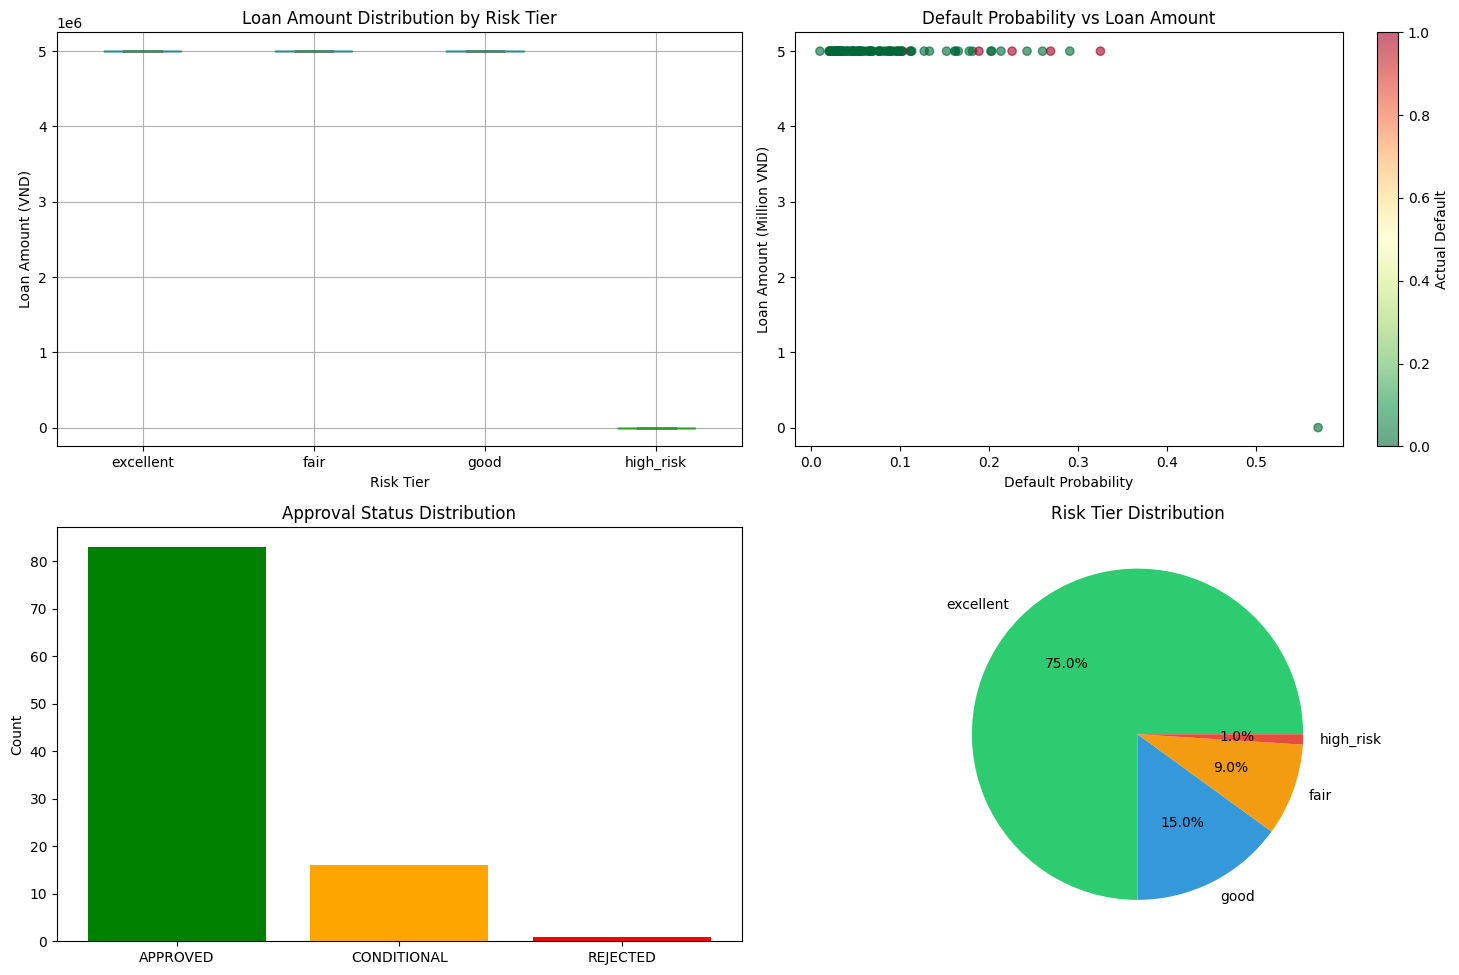

In [8]:
# Visualization 1: Loan Amount Distribution by Risk Tier
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loan amount by risk tier
ax1 = axes[0, 0]
results_df.boxplot(column='loan_amount', by='risk_tier', ax=ax1)
ax1.set_title('Loan Amount Distribution by Risk Tier')
ax1.set_xlabel('Risk Tier')
ax1.set_ylabel('Loan Amount (VND)')
ax1.get_figure().suptitle('')

# Plot 2: Default probability vs Loan amount
ax2 = axes[0, 1]
scatter = ax2.scatter(results_df['default_probability'], 
                     results_df['loan_amount']/1_000_000,
                     c=results_df['actual_default'], 
                     cmap='RdYlGn_r', alpha=0.6)
ax2.set_xlabel('Default Probability')
ax2.set_ylabel('Loan Amount (Million VND)')
ax2.set_title('Default Probability vs Loan Amount')
plt.colorbar(scatter, ax=ax2, label='Actual Default')

# Plot 3: Approval status distribution
ax3 = axes[1, 0]
approval_counts = results_df['approval_status'].value_counts()
ax3.bar(approval_counts.index, approval_counts.values, color=['green', 'orange', 'red'])
ax3.set_title('Approval Status Distribution')
ax3.set_ylabel('Count')

# Plot 4: Risk tier distribution
ax4 = axes[1, 1]
risk_counts = results_df['risk_tier'].value_counts()
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#c0392b']
ax4.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', colors=colors)
ax4.set_title('Risk Tier Distribution')

plt.tight_layout()
plt.show()

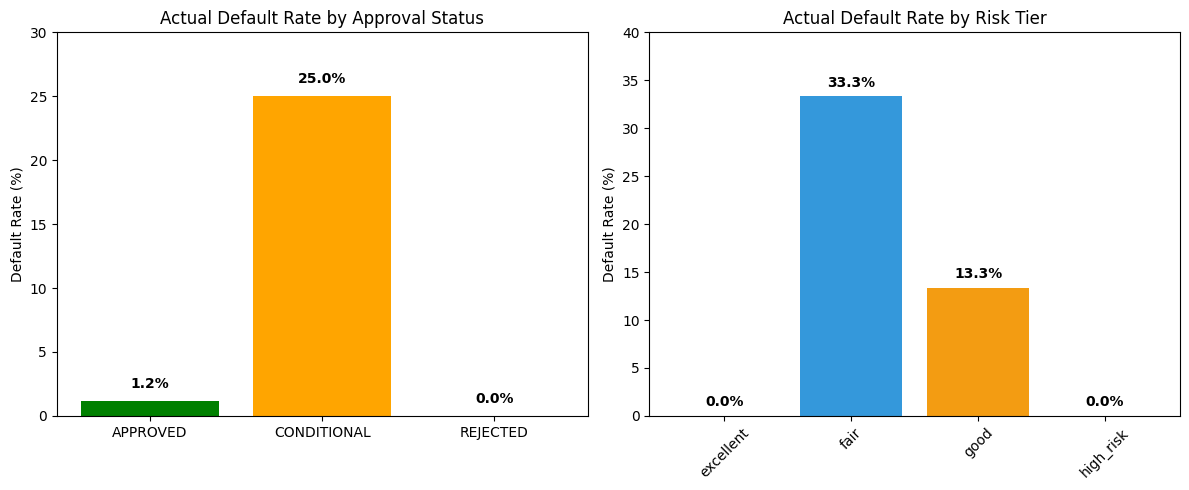

In [9]:
# Visualization 2: Default Rate Analysis
plt.figure(figsize=(12, 5))

# Left: Actual default rate by approval status
plt.subplot(1, 2, 1)
default_by_status = results_df.groupby('approval_status')['actual_default'].mean() * 100
plt.bar(default_by_status.index, default_by_status.values, color=['green', 'orange', 'red'])
plt.title('Actual Default Rate by Approval Status')
plt.ylabel('Default Rate (%)')
plt.ylim(0, max(default_by_status.values) * 1.2)

for i, v in enumerate(default_by_status.values):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Right: Actual default rate by risk tier
plt.subplot(1, 2, 2)
default_by_tier = results_df.groupby('risk_tier')['actual_default'].mean() * 100
plt.bar(default_by_tier.index, default_by_tier.values, color=colors[:len(default_by_tier)])
plt.title('Actual Default Rate by Risk Tier')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)
plt.ylim(0, max(default_by_tier.values) * 1.2)

for i, v in enumerate(default_by_tier.values):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [10]:
# Example: Single customer loan amount calculation
def estimate_customer_loan(customer_features):
    """
    Estimate loan amount for a single customer
    
    Parameters:
    -----------
    customer_features : dict or pd.Series
        Customer feature values
    
    Returns:
    --------
    Loan estimation result with explanation
    """
    # Predict default probability
    if isinstance(customer_features, dict):
        features_df = pd.DataFrame([customer_features])
    else:
        features_df = pd.DataFrame([customer_features])
    
    default_prob = model.predict_proba(features_df)[:, 1][0]
    
    # Extract relevant features for loan calculation
    income = customer_features.get('AMT_INCOME_TOTAL', customer_features.iloc[0] if isinstance(customer_features, pd.Series) else 0)
    debt = customer_features.get('AMT_CREDIT', 0)
    
    # Calculate loan amount
    result = calculate_loan_amount(
        default_prob=default_prob,
        income=income,
        existing_debt=debt,
        employment_length=2,  # Default values - adjust based on actual data
        credit_history_length=3,
        num_credits=2
    )
    
    # Print detailed explanation
    print("="*80)
    print("LOAN AMOUNT ESTIMATION REPORT")
    print("="*80)
    print(f"\n📊 CREDIT ASSESSMENT")
    print(f"   Default Probability: {result['default_probability']*100:.2f}%")
    print(f"   Risk Tier: {result['risk_tier'].upper()}")
    print(f"   Decision: {result['approval_status']}")
    print(f"\n💰 LOAN AMOUNT: {result['loan_amount']:,.0f} VND")
    print(f"\n📈 CALCULATION DETAILS:")
    print(f"   Risk-Based Limit: {result['details']['risk_based_limit']:,.0f} VND")
    print(f"   Income-Based Limit: {result['details']['income_based_limit']:,.0f} VND")
    print(f"   Adjustment Factor: {result['details']['adjustment_factor']:.3f}")
    print(f"   Tier Multiplier: {result['details']['tier_multiplier']:.2f}")
    print(f"   DTI Ratio: {result['details']['dti_ratio']*100:.1f}%")
    print("="*80)
    
    return result

# Test with a sample customer
sample_customer = X_test.iloc[0]
loan_estimate = estimate_customer_loan(sample_customer)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
LOAN AMOUNT ESTIMATION REPORT

📊 CREDIT ASSESSMENT
   Default Probability: 3.45%
   Risk Tier: EXCELLENT
   Decision: APPROVED

💰 LOAN AMOUNT: 5,000,000 VND

📈 CALCULATION DETAILS:
   Risk-Based Limit: 91,726,000 VND
   Income-Based Limit: 0 VND
   Adjustment Factor: 1.158
   Tier Multiplier: 1.00
   DTI Ratio: 0.0%


In [11]:
# Save the loan amount calculation function
joblib.dump({
    'calculate_loan_amount': calculate_loan_amount,
    'get_risk_tier': get_risk_tier,
    'constants': {
        'L_MAX': L_MAX,
        'K': K,
        'INCOME_FACTOR': INCOME_FACTOR,
        'MIN_LOAN': MIN_LOAN,
        'RISK_TIERS': RISK_TIERS
    }
}, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\loan_amount_calculator.pkl")

print("✅ Loan amount calculator saved successfully!")
print(f"   Location: C:\\Users\\Asus\\Documents\\GitHub\\Credit-Scoring\\output\\models\\loan_amount_calculator.pkl")

✅ Loan amount calculator saved successfully!
   Location: C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\loan_amount_calculator.pkl
